In [14]:
pip install transformers==2.6.0

     |████████████████████████████████| 542kB 4.9MB/s 
     |████████████████████████████████| 3.7MB 23.6MB/s 
     |████████████████████████████████| 1.1MB 42.4MB/s 
     |████████████████████████████████| 890kB 58.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=953521b161628fb883714696df266f5785493ff035ca04deb85f4343027fbcbd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [15]:
pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=071ee6f5e74030c6191b9d6603e5eaefe96bd7b1c3b08bd33b5c3f6661363db2
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


# Load MESH data

In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

file_path = "/content/drive/Shared drives/eHealth/dados/harena/information retrieval (1)/pmc_corpus__mesh_ne__labeled_v3.csv"
# file_path = "pmc_corpus__mesh_ne__labeled_v3.csv"


data = pd.read_csv(file_path, encoding="latin1").fillna(method="ffill")
data.head(10)

,Unnamed: 0,sentence_idx,word,tag
0,0,1,Objectives,O
1,1,1,The,O
2,2,1,purpose,O
3,3,1,of,O
4,4,1,this,O
5,5,1,study,O
6,6,1,was,O
7,7,1,to,O
8,8,1,investigate,O
9,9,1,in,O


In [0]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                     s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [0]:
getter = SentenceGetter(data)

words = [[word[0] for word in sentence] for sentence in getter.sentences]
labels = [[tag[1] for tag in sentence] for sentence in getter.sentences]

In [0]:
for w,t in zip(words, labels):
  print(w)
  print(t)

In [9]:
print('Max sentence length: ', max([len(w) for w in words]))

Max sentence length:  1098


In [0]:
tag_values = list(set(data["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}


In [19]:
len(tag2idx)

4

# Load data from tutorial https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

In [47]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

file_path = "/content/drive/Shared drives/eHealth/dados/harena/information retrieval (1)/ner_dataset.csv"

data = pd.read_csv(file_path, encoding="latin1").fillna(method="ffill")
data.tail(10)


FileNotFoundError: ignored

In [0]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [0]:
getter = SentenceGetter(data)

In [0]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [0]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [0]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

# Apply BERT

In [20]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


Using TensorFlow backend.


'1.5.0+cu101'

In [0]:
MAX_LEN = 75
bs = 32


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


In [0]:

# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-cased')

# tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
# model = model_class.from_pretrained(pretrained_weights)

In [0]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [0]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(words, labels)
]

In [0]:
tokenized_texts = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [0]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [28]:
for t, l in zip(tokenized_texts[0], labels[0]):
  print(t,'\t',l)


O 	 O
##bject 	 O
##ives 	 O
The 	 O
purpose 	 O
of 	 O
this 	 O
study 	 O
was 	 O
to 	 O
investigate 	 O
in 	 O
v 	 O
##ivo 	 O
visible 	 O
imaging 	 O
of 	 O
oral 	 O
sq 	 O
##ua 	 O
##mous 	 O
cell 	 O
car 	 O
##cin 	 O
##oma 	 O
OS 	 O
##CC 	 O
by 	 O
targeting 	 O
e 	 B-MESH
##pid 	 B-MESH
##er 	 B-MESH
##mal 	 B-MESH
growth 	 I-MESH
factor 	 I-MESH
receptor 	 O
E 	 O
##G 	 O
##F 	 O
##R 	 O
with 	 O
near 	 O
infrared 	 O
quantum 	 O
dots 	 O
Materials 	 O
and 	 O
methods 	 O
Quantum 	 O
dots 	 O
with 	 O
an 	 O
emission 	 O
wavelength 	 O
of 	 O
800 	 O
nm 	 O
Q 	 O
##D 	 O
##80 	 O
##0 	 O
were 	 O
con 	 O
##ju 	 O
##gated 	 O
to 	 O
mon 	 O
##oc 	 O
##lon 	 O
##al 	 O
antibodies 	 B-MESH
against 	 O
E 	 O
##G 	 O
##F 	 O
##R 	 O
resulting 	 O
in 	 O
the 	 O
probe 	 O
designated 	 O
as 	 O
Q 	 O
##D 	 O
##80 	 O
##0 	 O
- 	 O
E 	 O
##G 	 O
##F 	 O
##R 	 O
A 	 O
##b 	 O
OS 	 O
##CC 	 O
cell 	 B-MESH
line 	 I-MESH
B 	 O
##ca 	 O
##CD 	 O
##8 	 O
##8 	 O
##5 	 O
expressing 	 O
high

In [0]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [0]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [0]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [0]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [33]:
len(tr_inputs)

2474

In [0]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [0]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [36]:
len(train_dataloader.batch_sampler.sampler.data_source.tensors[1][0])

75

In [37]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'2.6.0'

In [38]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

In [0]:
model.cuda();


In [0]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [0]:
from seqeval.metrics import f1_score, accuracy_score


In [43]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Average train loss: 0.2692955505007353


Epoch:  33%|███▎      | 1/3 [00:21<00:43, 21.69s/it]

Validation loss: 0.19502059618631998
Validation Accuracy: 0.9325171257834135
Validation F1-Score: 0.3097199341021417

Average train loss: 0.17647091203775161


Epoch:  67%|██████▋   | 2/3 [00:42<00:21, 21.57s/it]

Validation loss: 0.1741333305835724
Validation Accuracy: 0.9388816013214789
Validation F1-Score: 0.5122950819672132

Average train loss: 0.13869452151732567


Epoch: 100%|██████████| 3/3 [01:04<00:00, 21.44s/it]

Validation loss: 0.17372157673041025
Validation Accuracy: 0.9394160229315455
Validation F1-Score: 0.5434697855750488



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


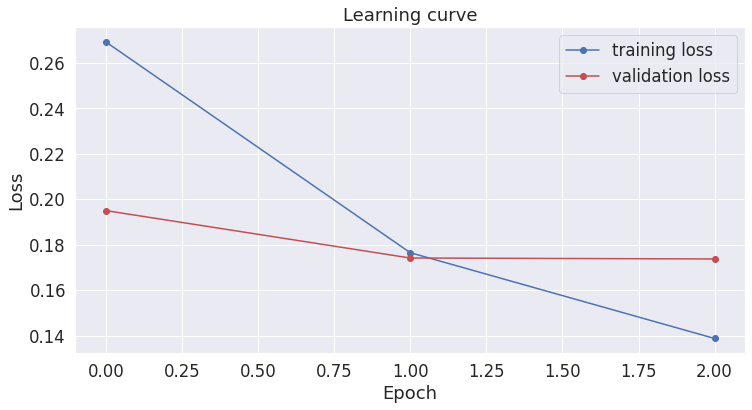

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


# Labeling new sentenes

In [0]:
test_sentence = "A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, but is not increased on inspiration. The latest episode of pain ended half an hour prior to her arrival. She is known to have hypertension and obesity. She denies smoking, diabetes, hypercholesterolemia, or a family history of heart disease. She currently takes no medications. Physical examination is normal. The EKG shows nonspecific changes. The urogenital system failled."


In [0]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()


In [0]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [0]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [54]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
O	A
O	58
O	-
O	year
O	-
O	old
O	African
O	-
O	American
O	woman
O	presents
O	to
O	the
O	ER
O	with
O	episodic
O	pressing
O	/
O	burning
O	anterior
B-MESH	chest
O	pain
O	that
O	began
O	two
O	days
O	earlier
O	for
O	the
O	first
O	time
O	in
O	her
O	life
O	.
O	The
O	pain
O	started
O	while
O	she
O	was
O	walking
O	,
O	radiates
O	to
O	the
O	back
O	,
O	and
O	is
O	accompanied
O	by
O	nausea
O	,
O	diaphoresis
O	and
O	mild
O	dyspnea
O	,
O	but
O	is
O	not
O	increased
O	on
O	inspiration
O	.
O	The
O	latest
O	episode
O	of
O	pain
O	ended
O	half
O	an
O	hour
O	prior
O	to
O	her
O	arrival
O	.
O	She
O	is
O	known
O	to
O	have
O	hypertension
O	and
B-MESH	obesity
O	.
O	She
O	denies
O	smoking
O	,
O	diabetes
O	,
O	hypercholesterolemia
O	,
O	or
O	a
O	family
O	history
O	of
B-MESH	heart
B-MESH	disease
O	.
O	She
O	currently
O	takes
O	no
O	medications
O	.
O	Physical
O	examination
O	is
O	normal
O	.
O	The
O	EKG
O	shows
O	nonspecific
O	changes
O	.
O	The
O	urogenital
O	system
O	failled
O	.
O	[SEP]
